# Pneumonia Detection Problem (Notebook 2)

We will build a CNN that takes  xray images and diagnoses pneumonia via classification 

**About the dataset**

ChestX-ray14 is a medical imaging dataset which comprises 112,120 frontal-view X-ray images of 30,805 (collected from the year of 1992 to 2015) unique patients with the text-mined fourteen common disease labels, mined from the text radiological reports via NLP techniques. It expands on ChestX-ray8 by adding six additional thorax diseases: Edema, Emphysema, Fibrosis, Pleural Thickening and Hernia

https://www.v7labs.com/open-datasets/chestx-ray14


Given the computational resources we got we will only work on a subset of this dataset and will build a binary classifier detecting pneumonia instead of a all 14 diseases with entire dataset 




In this notebook we will do the following:
1. Data prepapration and augmentation 
2. Pretrained model and transfer learning prep
3. Model Training and Evaluation

In [8]:
import numpy as np 
import pandas as pd 
import os
from random import sample
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf 
import keras 
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split 
from keras.applications.vgg16 import VGG16 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import pydicom 
from itertools import chain 
from pydicom import dcmread 
from skimage.io import imread 
from tqdm import tqdm 
import seaborn as sns 
from scipy.stats import mode 
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split 
import tensorflow as tf 
from keras import Model
from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint
from sklearn.metrics import precision_score ,recall_score ,f1_score,accuracy_score

## 1. Data Preparation and Augmentation

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
data = pd.read_csv('sample.csv')
data.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of diseases
5775,00008023_005.png,Infiltration,5,8023,35.0,M,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5372,00007917_005.png,Nodule,5,7917,35.0,F,PA,2494,2589,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
8364,00008745_022.png,Infiltration,22,8745,45.0,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [3]:
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [4]:
data["pneumonia_class"]=np.where(data["Pneumonia"]==1,1,0)

In [9]:
def create_splits(d):

    
    # Todo
    train_df, valid_df = train_test_split(d, 
                                   test_size = 0.2, 
                                   stratify = d['pneumonia_class'])

    p_inds = train_df[train_df.pneumonia_class==1].index.tolist()
    np_inds = train_df[train_df.pneumonia_class==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    p_inds = valid_df[valid_df.pneumonia_class==1].index.tolist()
    np_inds = valid_df[valid_df.pneumonia_class==0].index.tolist()
    np_sample = sample(np_inds,4*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]
    
    return train_df, valid_df

In [10]:
# use the splitted and sampled image indexes to create our test and train datasets
# make sure dataset is split in a balanced manner 
train,test=create_splits(data)
print(test["pneumonia_class"].value_counts()/len(test))
print(train["pneumonia_class"].value_counts()/len(train))

0    0.8
1    0.2
Name: pneumonia_class, dtype: float64
1    0.5
0    0.5
Name: pneumonia_class, dtype: float64


In [11]:
train

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of diseases,pneumonia_class
1589,00006968_002.png,Atelectasis|Effusion|Infiltration|Pneumonia,2,6968,68.0,M,AP,2500,2048,0.171,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,1
1585,00006966_004.png,Pneumonia,4,6966,47.0,M,PA,2988,2199,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
2312,00007109_027.png,Fibrosis|Pneumonia,23,7109,39.0,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
6939,00008347_009.png,Edema|Effusion|Infiltration|Pneumonia,9,8347,42.0,F,AP,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,1
2305,00007109_020.png,Fibrosis|Pneumonia,16,7109,38.0,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7362,00008468_036.png,Emphysema|Pneumothorax,35,8468,10.0,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,0
6560,00008251_010.png,No Finding,10,8251,39.0,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0
6296,00008164_006.png,No Finding,6,8164,42.0,F,PA,2718,2549,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0
6701,00008291_013.png,Infiltration,13,8291,33.0,F,AP,2048,2500,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [12]:
# it is necessary for data generator that labels are strings 
train.pneumonia_class=train.pneumonia_class.astype(str)
test.pneumonia_class=test.pneumonia_class.astype(str)

In [17]:
def my_image_augmentation(myitem):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    # Image pre-processing:
    # Remove potential noise from our images (Otsu method)
    # Enforce some normalization across images
    # Enlarge your dataset
    # Resize for CNN arcitectures' required input.
    if (myitem== 'train'):
        my_idg = ImageDataGenerator(rescale=1. / 255.0,
                                  horizontal_flip = True, 
                                  vertical_flip = False, 
                                  height_shift_range= 0.01, 
                                  width_shift_range=0.01, 
                                  rotation_range=20, 
                                  shear_range = 0.05,
                                  zoom_range=0.01)
    else:
        
    
        my_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    
    
    return my_idg

def make_train_gen(my_train_idg,train_df,batch_size,img_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory="images/", 
                                          x_col ="Image Index" ,
                                          y_col ="pneumonia_class" ,
                                          class_mode = 'binary',
                                          target_size = (img_size,img_size), 
                                          batch_size = batch_size
                                          )
     # Todo

    return train_gen


def make_val_gen(my_val_idg,val_data,batch_size,img_size):
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory="images/",
                                             x_col = "Image Index"
                                             ,y_col = "pneumonia_class",
                                             class_mode = 'binary',
                                             target_size = (img_size,img_size) ,
                                             batch_size = batch_size ) 
    return val_gen

In [18]:
## May want to pull a single large batch of random validation data for testing after each epoch:
my_val_idg=my_image_augmentation("val")
val_gen=make_val_gen(my_val_idg,test,200,224)
valX, valY = val_gen.next()

Found 100 validated image filenames belonging to 2 classes.


Found 156 validated image filenames belonging to 2 classes.


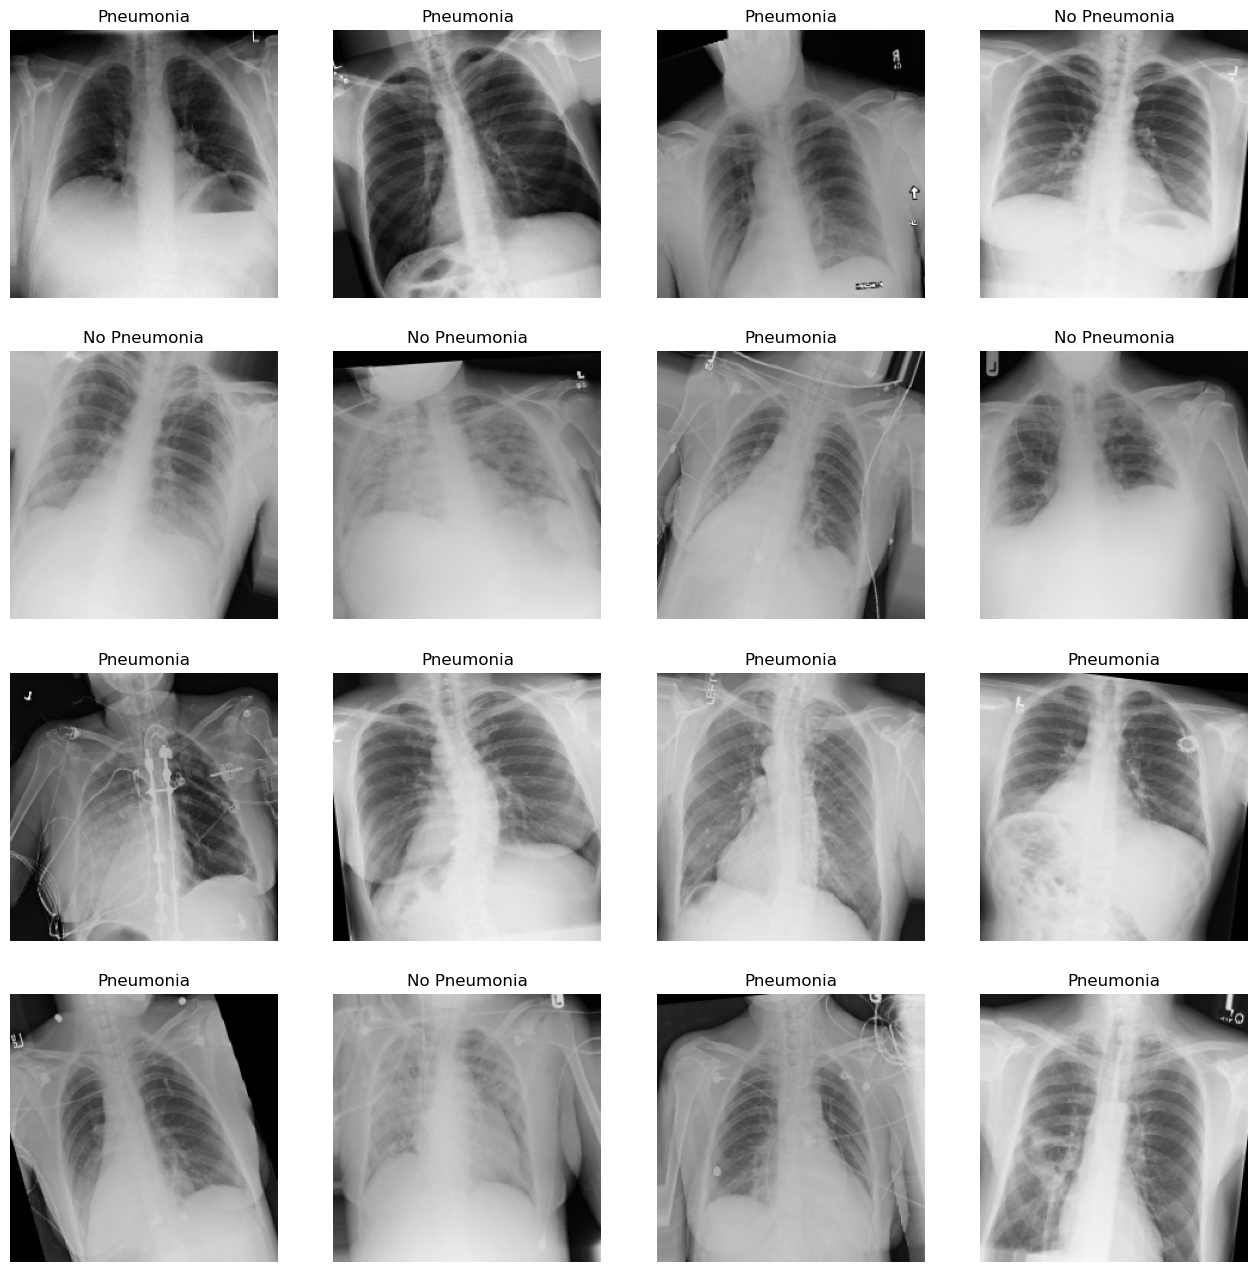

In [19]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
my_train_idg=my_image_augmentation("train")
train_gen=make_train_gen(my_train_idg,train,128,224)
temp_x, temp_y = next(train_gen)
fig, axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(temp_x, temp_y, axs.flatten()):
    c_ax.imshow(c_x, cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## 2. Train and evaluate our model: 

In [20]:
def load_pretrained_model():
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model
vgg_model= load_pretrained_model()
vgg_model.summary()

553467096/553467096 [==============================] - 173s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

In [21]:
weight_path="./xray_class_my_model.best.hdf5"
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= min, 
                             save_weights_only = True)
early = EarlyStopping(monitor= 'val_loss', 
                      mode= min, 
                      patience=5)
callbacks_list = [checkpoint, early]
for layer in vgg_model.layers[0:17]:
    layer.trainable = False
model1 = Sequential()
# Add the convolutional part of the VGG16 model from above.
model1.add(vgg_model)
# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
model1.add(Flatten())
model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
    
## Set our optimizer, loss function, and learning rate
optimizer = keras.optimizers.Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
    
model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    

model1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1

/opt/miniconda3/lib/python3.9/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
#training 
history=model1.fit_generator(train_gen, 
                                  validation_data = (valX, valY),
                                  callbacks=callbacks_list,
                                  epochs = 15)

Epoch 1/15
18/18 [==============================] - 80s 4s/step - loss: 0.7525 - binary_accuracy: 0.5074 - val_loss: 0.7625 - val_binary_accuracy: 0.4050

Epoch 00001: val_loss improved from inf to 0.76252, saving model to ./xray_class_my_model.best.hdf5
Epoch 2/15
18/18 [==============================] - 58s 3s/step - loss: 0.7081 - binary_accuracy: 0.5389 - val_loss: 0.6377 - val_binary_accuracy: 0.6550

Epoch 00002: val_loss improved from 0.76252 to 0.63767, saving model to ./xray_class_my_model.best.hdf5
Epoch 3/15
18/18 [==============================] - 62s 3s/step - loss: 0.6833 - binary_accuracy: 0.5672 - val_loss: 0.7373 - val_binary_accuracy: 0.4600

Epoch 00003: val_loss did not improve from 0.63767
Epoch 4/15
18/18 [==============================] - 62s 3s/step - loss: 0.6813 - binary_accuracy: 0.5830 - val_loss: 0.6694 - val_binary_accuracy: 0.6050

Epoch 00004: val_loss did not improve from 0.63767
Epoch 5/15
18/18 [==============================] - 66s 4s/step - loss: 0.

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [16]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model1.load_weights(weight_path)
pred_Y = model1.predict(valX, batch_size = 32, verbose = True)

200/200 [==============================] - 6s 32ms/step


In [17]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fpr,tpr,_=metrics.roc_curve(t_y,p_y)
    plt.plot(fpr,tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    return
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
            FP += 1
        if y_actual[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
            FN += 1

    return(TP, FP, TN, FN)
## what other performance statistics do you want to include here besides AUC? 


def plot_confusion_matrix(t_y,p_y):
    sns.heatmap(metrics.confusion_matrix(t_y,p_y),annot=True)

def clinical_metrics(t_y,p_y,verbose=1):
    """ takes in true values and prediction and returns specificity and sensitivity"""
    tn, fp, fn, tp = perf_measure(t_y,p_y)
    try:
        specificity= tn/(tn+fp)
    except:
        print("Zero division")
        specificity=None
    try:
        sensitivity=tp/(tp+fn)
    except:
        print("Zero division")
        sensitivity=None
        
    precision=precision_score(t_y,p_y)
    f1=f1_score(t_y,p_y)
    accuracy=accuracy_score(t_y,p_y)
    if verbose==1:
        print(f" Model has a sensitivity AKA recall of {sensitivity:.2f} \n Model has specificity of {specificity:.2f} \n Model has precision of {precision:.2f}\n Model has f1_score of {f1:.2f}\n Model has accuracy of {accuracy:.2f}")
    return {"accuracy":accuracy,"precision":precision,"f1":f1,"recall":sensitivity}
   

    
#Also consider plotting the history of your model training:

plt.style.use('seaborn-deep')
def plot_history(history):
    histo=history.history
    fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(20,10))
    ax1.plot(histo["val_loss"],"r-")
    ax1.plot(histo["loss"][1:],"b-")
    ax1.legend(["val_loss","train_loss"])
    ax2.plot(histo["val_binary_accuracy"][1:],"r-")
    ax2.plot(histo["binary_accuracy"],"b-")
    ax2.legend(["val_accuracy","train_accuracy"])
    plt.suptitle("Performance Over Training Epochs",fontsize=20)

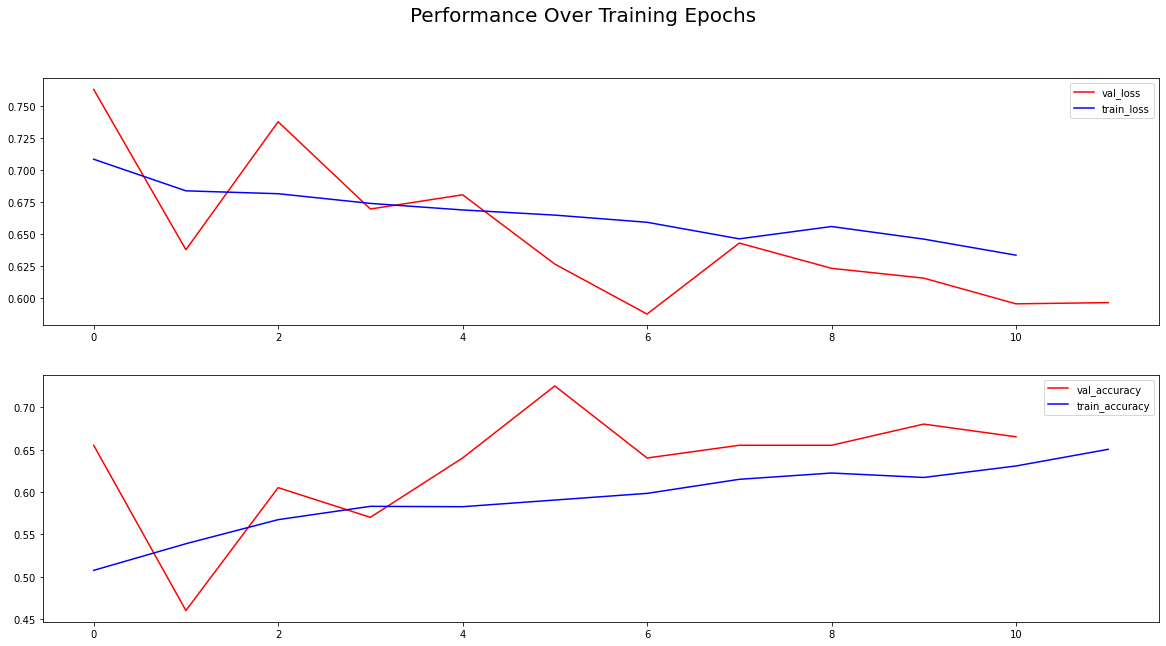

In [18]:
## plot figures
plot_history(history)

Note here I skipped the first epich as it was too large of a loss that it scaled up the graph to a smaller resolution making the later epochs seem like a straight line 

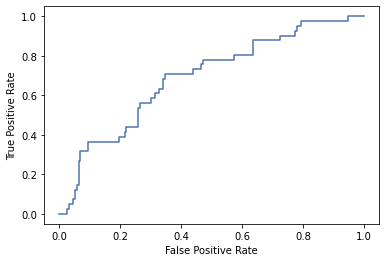

In [19]:
plot_auc(valY,pred_Y)


 Model has a sensitivity AKA recall of 0.17 
 Model has specificity of 0.34 
 Model has precision of 0.34
 Model has f1_score of 0.35
 Model has accuracy of 0.72


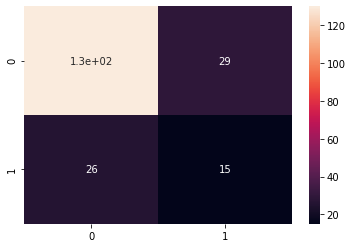

In [20]:
#assuming threshold is 0.5
pred=[1 if i>0.5 else 0 for i in pred_Y ]
clinical_metrics(valY,pred)
plot_confusion_matrix(valY,pred)